In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import json

from statistics import mode

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [18]:
absa_final_subset = absa_final[:1001]
absa_final_subset

,index,sentence,aspect,sentiment_coded,polarity
0,0,I charge it at night and skip taking the cord ...,cord,2,neutral
1,1,I charge it at night and skip taking the cord ...,battery life,1,positive
2,2,The tech guy then said the service center does...,service center,0,negative
3,3,The tech guy then said the service center does...,"""sales"" team",0,negative
4,4,The tech guy then said the service center does...,tech guy,2,neutral
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1,positive
997,997,Other than that its a great performing machine...,performing,1,positive
998,998,"Called tech support and got the usual Acer ""We...",software,0,negative
999,999,"Called tech support and got the usual Acer ""We...",software,0,negative


In [9]:
# absa_final_subset.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_SUBSET_1000.csv')

## OpenAI / GPT

In [10]:
openai_client

### ABSA

In [10]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [19]:
## Prompts

system_prompt = """ You classify the sentiment of a specific aspect within a text. 
                    
                    ### Examples ###
                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                        Aspect: 'Mac software', Text: 'Everything is so easy to use, Mac software is just so much simpler than Microsoft software.'
                    
                    Answer: "The sentence “Everything is so easy to use, Mac software is just so much simpler than Microsoft software.” clearly conveys a positive sentiment towards the aspect “Mac software.” 
                    First, the sentence highlights the overall ease of use with the phrase “so easy to use.” 
                    This indicates that the person finds the software intuitive and user-friendly, which is a positive expression. 
                    Then, a direct comparison is made with Microsoft software, stating that “Mac software is just so much simpler.” 
                    This comparison emphasizes the superiority of Mac software in terms of simplicity. Overall, the positive language (“easy to use,” “simpler”) demonstrates that the person perceives Mac software as more user-friendly and less complicated compared to Microsoft software, resulting in a positive sentiment.",
                    'final_anwer': positive

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                        Aspect: 'external monitor', Text: 'Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares' 
                    Answer: "The sentence “Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares.” expresses a neutral sentiment regarding the aspect “external monitor.” 
                    First, a potential limitation is acknowledged, as the speaker notes that a 13-inch screen is small, particularly for a desktop replacement. 
                    However, this concern is immediately addressed by mentioning the external monitor, with the phrase “but with an external monitor, who cares.” 
                    This suggests that the issue of screen size is resolved by the external monitor, but the tone is indifferent rather than strongly positive or negative. 
                    The external monitor is presented as a practical solution without eliciting strong emotions, leading to a neutral overall sentiment.",
                    'final_answer': neutral
                    """

user_prompt = ("""       
Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
""")


# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'steps', 'answers', 'generated_label']) #[index, text, aspect, all_steps, answers, consistent_answer]

# Zähler für das Einfügen in das DataFrame
row_counter = 0


n = 3

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']
    #print(text)

    answers = []
    all_steps = []

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role":"system",
                "content": system_prompt
                },
                {
                "role": "user",
                 "content": (user_prompt + "Aspect: "+ f"{aspect}" + "Text: " + f"{text}")
                }
            ],
            temperature = 0.5,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed #response.choices[0].message.content
            
            result_step = response_content.steps
            final_answer = response_content.final_answer

            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )

           # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df.loc[row_counter] = [index, text, aspect, all_steps, answers, consistent_answer]

            row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0 n=  0 Label:  positive
0 n=  1 Label:  positive
0 n=  2 Label:  positive
1 n=  0 Label:  positive
1 n=  1 Label:  positive
1 n=  2 Label:  positive
2 n=  0 Label:  negative
2 n=  1 Label:  negative
2 n=  2 Label:  negative
3 n=  0 Label:  neutral
3 n=  1 Label:  negative
3 n=  2 Label:  neutral
4 n=  0 Label:  negative
4 n=  1 Label:  negative
4 n=  2 Label:  negative
5 n=  0 Label:  positive
5 n=  1 Label:  positive
5 n=  2 Label:  positive
6 n=  0 Label:  positive
6 n=  1 Label:  positive
6 n=  2 Label:  positive
7 n=  0 Label:  positive
7 n=  1 Label:  positive
7 n=  2 Label:  positive
8 n=  0 Label:  positive
8 n=  1 Label:  positive
8 n=  2 Label:  positive
9 n=  0 Label:  positive
9 n=  1 Label:  positive
9 n=  2 Label:  positive
10 n=  0 Label:  positive
10 n=  1 Label:  positive
10 n=  2 Label:  positive
11 n=  0 Label:  positive
11 n=  1 Label:  positive
11 n=  2 Label:  positive
12 n=  0 Label:  positive
12 n=  1 Label:  positive
12 n=  2 Label:  positive
13 n=  0 Label:  p

In [20]:
results_gpt_df

,index,sentence,aspect,steps,answers,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[[explanation='The sentence ""I charge it at ni...","[positive, positive, positive]",positive
1,1,I charge it at night and skip taking the cord ...,battery life,"[[explanation='The sentence ""I charge it at ni...","[positive, positive, positive]",positive
2,2,The tech guy then said the service center does...,service center,"[[explanation=""The sentence discusses a situat...","[negative, negative, negative]",negative
3,3,The tech guy then said the service center does...,"""sales"" team","[[explanation='In the sentence, ""The tech guy ...","[neutral, negative, neutral]",neutral
4,4,The tech guy then said the service center does...,tech guy,"[[explanation=""The sentence discusses an inter...","[negative, negative, negative]",negative
...,...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,"[[explanation='The sentence ""iPhotos is an exc...","[positive, positive, positive]",positive
997,997,Other than that its a great performing machine...,performing,"[[explanation='The sentence ""Other than that i...","[positive, positive, positive]",positive
998,998,"Called tech support and got the usual Acer ""We...",software,"[[explanation='The sentence ""Called tech suppo...","[negative, negative, negative]",negative
999,999,"Called tech support and got the usual Acer ""We...",software,"[[explanation='The sentence ""Called tech suppo...","[negative, negative, negative]",negative


In [21]:
### Datenaufbereitung

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_ver = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_ver['generated_label'] = results_gpt_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final = results_gpt_df_ver[results_gpt_df_ver['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)

/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_95813/3145298559.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_df_ver['generated_label'] = results_gpt_df_ver['generated_label'].replace({


In [22]:
results_gpt_df_final

,index,sentence,aspect,steps,answers,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[[explanation='The sentence ""I charge it at ni...","[positive, positive, positive]",1
1,1,I charge it at night and skip taking the cord ...,battery life,"[[explanation='The sentence ""I charge it at ni...","[positive, positive, positive]",1
2,2,The tech guy then said the service center does...,service center,"[[explanation=""The sentence discusses a situat...","[negative, negative, negative]",0
3,3,The tech guy then said the service center does...,"""sales"" team","[[explanation='In the sentence, ""The tech guy ...","[neutral, negative, neutral]",2
4,4,The tech guy then said the service center does...,tech guy,"[[explanation=""The sentence discusses an inter...","[negative, negative, negative]",0
...,...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,"[[explanation='The sentence ""iPhotos is an exc...","[positive, positive, positive]",1
997,997,Other than that its a great performing machine...,performing,"[[explanation='The sentence ""Other than that i...","[positive, positive, positive]",1
998,998,"Called tech support and got the usual Acer ""We...",software,"[[explanation='The sentence ""Called tech suppo...","[negative, negative, negative]",0
999,999,"Called tech support and got the usual Acer ""We...",software,"[[explanation='The sentence ""Called tech suppo...","[negative, negative, negative]",0


In [23]:

# CSV abspeichern 
results_gpt_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_SelfConsistency_GPT.csv', encoding='utf-8-sig')


### Evaluation

In [24]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gpt_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.82
Precision (macro): 0.78
Recall (macro): 0.76
F1-Score (macro): 0.76
Confusion Matrix:
[[344  15  19]
 [ 19 397  32]
 [ 52  39  84]]


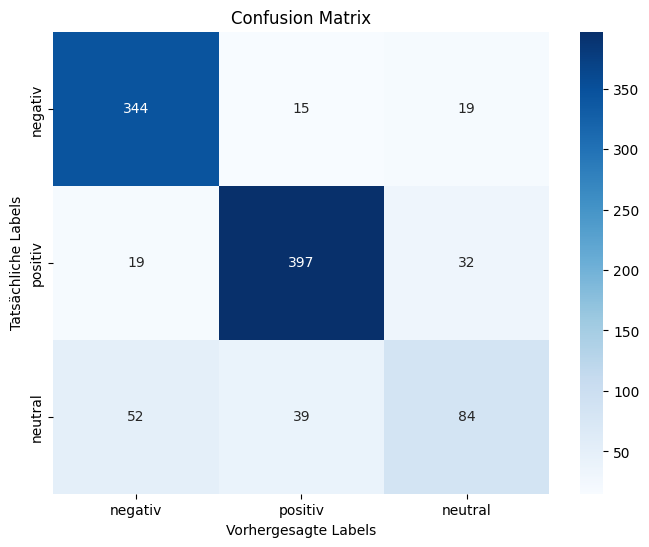

In [25]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

### SemEval-2014

In [34]:
absa_final_subset = absa_final[:1001]
absa_final_subset

,index,sentence,aspect,sentiment_coded,polarity
0,0,I charge it at night and skip taking the cord ...,cord,2,neutral
1,1,I charge it at night and skip taking the cord ...,battery life,1,positive
2,2,The tech guy then said the service center does...,service center,0,negative
3,3,The tech guy then said the service center does...,"""sales"" team",0,negative
4,4,The tech guy then said the service center does...,tech guy,2,neutral
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1,positive
997,997,Other than that its a great performing machine...,performing,1,positive
998,998,"Called tech support and got the usual Acer ""We...",software,0,negative
999,999,"Called tech support and got the usual Acer ""We...",software,0,negative


In [35]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
    Use this JSON Schema: Result = {'steps':str, 'final_answer': str} 
    You classify the sentiment of a specific aspect within a text. 
    ### Examples ###
    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
        Aspect: 'Mac software', Text: 'Everything is so easy to use, Mac software is just so much simpler than Microsoft software.'
    Answer: {'steps':"The sentence “Everything is so easy to use, Mac software is just so much simpler than Microsoft software.” clearly conveys a positive sentiment towards the aspect “Mac software.” 
    First, the sentence highlights the overall ease of use with the phrase “so easy to use.” 
    This indicates that the person finds the software intuitive and user-friendly, which is a positive expression. 
    Then, a direct comparison is made with Microsoft software, stating that “Mac software is just so much simpler.” 
    This comparison emphasizes the superiority of Mac software in terms of simplicity. Overall, the positive language (“easy to use,” “simpler”) demonstrates that the person perceives Mac software as more user-friendly and less complicated compared to Microsoft software, resulting in a positive sentiment.",
    'final_anwer': positive}

    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
        Aspect: 'external monitor', Text: 'Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares' 
    Answer: {'steps': "The sentence “Size: I know 13 is small (especially for a desktop replacement) but with an external monitor, who cares.” expresses a neutral sentiment regarding the aspect “external monitor.” 
    First, a potential limitation is acknowledged, as the speaker notes that a 13-inch screen is small, particularly for a desktop replacement. 
    However, this concern is immediately addressed by mentioning the external monitor, with the phrase “but with an external monitor, who cares.” 
    This suggests that the issue of screen size is resolved by the external monitor, but the tone is indifferent rather than strongly positive or negative. 
    The external monitor is presented as a practical solution without eliciting strong emotions, leading to a neutral overall sentiment.",
    'final_answer': neutral}
    """,
    generation_config={"response_mime_type": "application/json","temperature":0.8})

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Anzahl der Wiederholungen für Self-Consistency
num_samples = 3

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']
    
    # Liste zum Speichern von Antworten und deren Details
    answers = []
    all_steps = []
    
    try:
        # Self-Consistency: Mehrere Antworten generieren
        for _ in range(num_samples):
            # GenAI Model-Aufruf für die Sentiment-Klassifikation
            response = genai_model.generate_content(f"""Classify the sentiment for the following aspect in the given text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’]. 
                                                    Aspect: {aspect}, Text: {text}""")
            llm_output = response.text
         
            # Antwort parsen und speichern
            resp_dict = json.loads(llm_output)
            steps = resp_dict['steps']
            final_result = resp_dict['final_answer']

            # In Liste hinzufügen
            answers.append(final_result)
            all_steps.append(steps)

            print("Index: ", index, "n= ",_ , "Label: ", final_result)

        
        # Mehrheit der final answers bestimmen (Voting-Mechanismus)
        try:
            most_common_answer = mode(answers)
        except StatisticsError:
            # Wenn mehrere Modi vorhanden sind, nimm den ersten Wert von multimode()
            most_common_answer = multimode(answers)[0]
            print(f"Mehrere häufigste Antworten für Index {index}, Auswahl: {most_common_answer}")


        # Ergebnis in das DataFrame speichern
        results_gemini_df.loc[row_counter] = [index, text, aspect, all_steps, answers, most_common_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

Index:  0 n=  0 Label:  positive
Index:  0 n=  1 Label:  positive
Index:  0 n=  2 Label:  positive
Index:  1 n=  0 Label:  positive
Index:  1 n=  1 Label:  positive
Index:  1 n=  2 Label:  positive
Index:  2 n=  0 Label:  negative
Index:  2 n=  1 Label:  negative
Index:  2 n=  2 Label:  negative
Index:  3 n=  0 Label:  neutral
Index:  3 n=  1 Label:  neutral
Index:  3 n=  2 Label:  neutral
Index:  4 n=  0 Label:  negative
Index:  4 n=  1 Label:  negative
Index:  4 n=  2 Label:  negative
Index:  5 n=  0 Label:  positive
Index:  5 n=  1 Label:  positive
Index:  5 n=  2 Label:  positive
Index:  6 n=  0 Label:  positive
Index:  6 n=  1 Label:  positive
Index:  6 n=  2 Label:  positive
Index:  7 n=  0 Label:  positive
Index:  7 n=  1 Label:  positive
Index:  7 n=  2 Label:  positive
Index:  8 n=  0 Label:  positive
Index:  8 n=  1 Label:  positive
Index:  8 n=  2 Label:  positive
Index:  9 n=  0 Label:  positive
Index:  9 n=  1 Label:  positive
Index:  9 n=  2 Label:  positive
Index:  10 n=

In [36]:
results_gemini_df

,index,sentence,aspect,all_steps,all_labels,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[The sentence ""I charge it at night and skip t...","[positive, positive, positive]",positive
1,1,I charge it at night and skip taking the cord ...,battery life,"[The statement ""I charge it at night and skip ...","[positive, positive, positive]",positive
2,2,The tech guy then said the service center does...,service center,[The statement “The tech guy then said the ser...,"[negative, negative, negative]",negative
3,3,The tech guy then said the service center does...,"""sales"" team",[The provided text expresses a neutral sentime...,"[neutral, neutral, neutral]",neutral
4,4,The tech guy then said the service center does...,tech guy,[The provided text expresses a negative sentim...,"[negative, negative, negative]",negative
...,...,...,...,...,...,...
968,996,iPhotos is an excellent program for storing an...,program,[The sentence “iPhotos is an excellent program...,"[positive, positive, positive]",positive
969,997,Other than that its a great performing machine...,performing,"[The sentence ""Other than that its a great per...","[positive, positive, positive]",positive
970,998,"Called tech support and got the usual Acer ""We...",software,[The sentence “Called tech support and got the...,"[negative, negative, negative]",negative
971,999,"Called tech support and got the usual Acer ""We...",software,[The sentence “Called tech support and got the...,"[negative, negative, negative]",negative


In [37]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_95813/3834408573.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({


In [38]:
results_gemini_df_final_ver

,index,sentence,aspect,all_steps,all_labels,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,"[The sentence ""I charge it at night and skip t...","[positive, positive, positive]",1
1,1,I charge it at night and skip taking the cord ...,battery life,"[The statement ""I charge it at night and skip ...","[positive, positive, positive]",1
2,2,The tech guy then said the service center does...,service center,[The statement “The tech guy then said the ser...,"[negative, negative, negative]",0
3,3,The tech guy then said the service center does...,"""sales"" team",[The provided text expresses a neutral sentime...,"[neutral, neutral, neutral]",2
4,4,The tech guy then said the service center does...,tech guy,[The provided text expresses a negative sentim...,"[negative, negative, negative]",0
...,...,...,...,...,...,...
968,996,iPhotos is an excellent program for storing an...,program,[The sentence “iPhotos is an excellent program...,"[positive, positive, positive]",1
969,997,Other than that its a great performing machine...,performing,"[The sentence ""Other than that its a great per...","[positive, positive, positive]",1
970,998,"Called tech support and got the usual Acer ""We...",software,[The sentence “Called tech support and got the...,"[negative, negative, negative]",0
971,999,"Called tech support and got the usual Acer ""We...",software,[The sentence “Called tech support and got the...,"[negative, negative, negative]",0


In [39]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv("""/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SelfConsistency_GEMINI.csv""")


#### Evaluation

In [40]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix_gemini)

Accuracy: 0.83
Precision (macro): 0.78
Recall (macro): 0.78
F1-Score (macro): 0.78
Confusion Matrix:
[[326  12  29]
 [ 10 392  35]
 [ 38  38  93]]


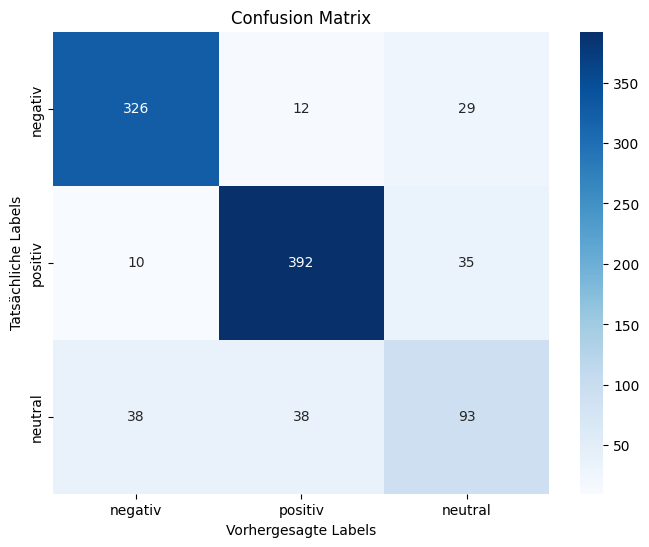

In [41]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gemini, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()